In [1]:
import collections
import datetime
import os
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

sys.path.append(os.path.abspath('../Data'))
import queries

In [ ]:
# server = 'VT1'
# schema = 'SRSHNKDIG'

# server = 'MA3'
# schema = 'SRSANBDIG'

# server = 'VT3'
# schema = 'WCS01600'

features = queries.get_profit_ces_qty_by_day(server, schema)
features.describe().transpose()

In [5]:
Models = collections.namedtuple('Models', ['MODEL', 'PARAMS'])
Model_Params = collections.namedtuple('Model_Params', ['LOSS', 'OPTIMIZER', 
                                      'EPOCHS', 'CALLBACKS', 'VERBOSE'])

In [161]:
class schema_ML():
    def __init__(self, schema, df):
        
        # Store initial data.
        self.schema = schema
        self.df_initial = df
        
        self.models = {}
        self.model_params = Model_Params('mae', 'adam', 500, [], 2)
        
        self.train_performance = {}
        self.test_performance = {}
        self.mfe = {}
        self.mae = {}
        self.mse = {}
        self.rmse = {}
        
        # Preprocess data.
        self.preprocess()
        
    def preprocess(self):
        
        # Reference DF
        df = self.df_initial
        
        # Combine individual date columns to single index
        df = df.rename(columns={'TYEAR':'YEAR', 'TMON':'MONTH', 'TDAY':'DAY'})
        df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
        df = df.drop(columns=['YEAR', 'MONTH', 'DAY'])
        df.set_index('DATE', inplace=True)
        
        # Insert zeros for missing dates
        df = self.add_missing_dates(df)
        self.df = df
        df.plot(subplots=True, title='Initial Data') 
        
        plot_acf(df['PROFIT'], lags=31)
        plot_pacf(df['PROFIT'], lags=31)
        
        # Add daily average columns
        df = self.add_daily_averages(df)
        
        # Add date columns
        df = self.add_date_columns(df)
        
        # Add differencing
        df = self.add_differencing(df)
        self.differenced_df = df
        df.plot(subplots=True, title='Added Differencing')
        
        # Normalize using scaler
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled = scaler.fit_transform(df.values)
        df = pd.DataFrame(scaled, columns=df.columns)
        df.plot(subplots=True, title='Added Normalization')
        self.normalized_df = df
        self.scaler = scaler
        
        # Split into train/val/test
        train_df, test_df = self.train_test_split(df)
        
        self.train_df = train_df
        self.test_df = test_df
        
    def add_missing_dates(self, df):
        missing_dates = pd.date_range(start=df.index[0], end=df.index[-1]).difference(df.index)
        n = len(missing_dates)
        m = len(df.columns)
        missing_dates_data = np.zeros((n,m))
        missing_dates_df = pd.DataFrame(missing_dates_data, index=missing_dates, columns=df.columns)
        dfs = [df, missing_dates_df]
        df = pd.concat(dfs)
        df['Date'] = df.index
        df = df.sort_values(by='Date')
        df.set_index('Date', inplace=True)
        
        return df
    
    def add_daily_averages(self, df):
        indexes = df.index.to_numpy()
        data = df.to_numpy()
        columns = list(df)

        rows = data.shape[0]
        cols = data.shape[1]
        avgcol_names = []
        avgcols = []
        
        for y in range(0, cols):
            avgcol = np.zeros((rows,1))
            col = data[:,y]
            
            for d in range(0, 365):
                day_d_entries = col[d: len(col): 365]
                day_d_entries[day_d_entries == 0] = np.nan
                avg = np.nanmean(day_d_entries)
                avgcol[d: len(col): 365] = avg
                
            avgcols.append(avgcol)
            avgcol_names.append(columns[y] + '_DAY_AVG')
        
        for newcol in avgcols:
            data = np.concatenate((data, newcol), axis=1)
            
        df = pd.DataFrame(data, index=df.index, columns=columns + avgcol_names).fillna(0)
        return df
        
    def add_date_columns(self, df):
        # df['DAY'] = df.index.day
        # df['MONTH'] = df.index.month
        
        return df
        
    def add_differencing(self, df):
        df = df.diff(7)
        
        return df.dropna()
        
    def train_test_split(self, df):
        n = len(df)
        pct_test = (np.log2(n/2) * 0.01)
        num_test = int(n * pct_test)
        num_train = n - num_test
        
        train = df[:num_train]
        test = df[num_train:]
        
        return train, test
    
    def add_lag(self, df):
        lags = [1, 7, 14, 21]
        cols = df.filter(regex='^((?!AVG).)*$').columns
        
        lagged = df.assign(**{
            '{} (t-{})'.format(col, t): df[col].shift(t)
            for t in lags
            for col in cols
        })
        
        return lagged.dropna()
    
    def reshape(self, X):
        X = X.values.reshape((X.shape[0], 1, X.shape[1]))
        
        return X
    
    def get_train_and_test(self, pred_col):
        train = self.train_df
        test = self.test_df

        train = self.add_lag(train)
        test = self.add_lag(test)

        X_train = train.filter(regex='t-|AVG')
        Y_train = train.filter(regex='^(' + pred_col + '$)')
        X_test = test.filter(regex='t-|AVG')
        Y_test = test.filter(regex='^(' + pred_col + '$)')
        
        print(X_train.columns)
    
        X_train, X_test = self.reshape(X_train), self.reshape(X_test)
        
        return X_train, Y_train, X_test, Y_test
        
    def evaluate_and_plot(self, pred_col='PROFIT', model_name='', model=None, model_params=None):
        
        if model is not None:
        
            # Add model to dictionary
            if model_params == None:
                model_params = self.model_params

            if model is not None:
                self.models[model_name] = Models(model, model_params)

            # Get training and validation data
            X_train, Y_train, X_test, Y_test = self.get_train_and_test(pred_col)

            # Compile model    
            model.compile(loss=model_params.LOSS, optimizer=model_params.OPTIMIZER)
            
            # Fit model to training data
            history = model.fit(X_train, Y_train, epochs=model_params.EPOCHS, 
                                callbacks=model_params.CALLBACKS, validation_data=(X_test, Y_test),
                                verbose=model_params.VERBOSE, shuffle=False)

            # Add validation information to dictionary
            self.train_performance[model_name] = min(history.history['loss'])
            self.test_performance[model_name] = min(history.history['val_loss'])
            
            # Plot train vs. val losses
            plt.plot(history.history['loss'], label='train')
            plt.plot(history.history['val_loss'], label='val')
            plt.title('Training Loss vs. Test Loss')
            plt.xlabel('# of Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
            
            # Calculate performance metrics and add to dictionaries
            expected = Y_test.values
            predicted = model(X_test)
            forecast_errors = [expected[i] - predicted[i] for i in range(len(expected))]
            
            mfe = np.mean(forecast_errors)
            mae = mean_absolute_error(expected, predicted)
            mse = mean_squared_error(expected, predicted)
            rmse = np.sqrt(mse)
            
            self.mfe[model_name] = mfe
            self.mae[model_name] = mae
            self.mse[model_name] = mse
            self.rmse[model_name] = rmse
            
            # Plot expected vs predicted
            plt.figure(figsize=(40,8))
            diff = self.test_df.index.shape[0] - expected.shape[0]
            plt.plot(self.test_df.index[diff:], expected, label='Expected', marker='.', zorder=-10)
            plt.scatter(self.test_df.index[diff:], predicted, label='Predicted', edgecolors='k', c='#2ca02c', s=64)
            plt.show()
            
            ### TEST - Inverse transform scaler ###
            
#             scaler = self.scaler
#             df_one = self.train_df
#             df_three = self.test_df
#             expected_df = pd.DataFrame(expected, index=Y_test.index, columns=Y_test.columns)
#             predicted_df = pd.DataFrame(predicted.numpy(), index=Y_test.index, columns=Y_test.columns)
            
#             expected_frames = [df_one[['PROFIT', 'CES']], expected_df, df_three[['PROFIT', 'CES']]]
#             predicted_frames = [df_one[['PROFIT', 'CES']], predicted_df, df_three[['PROFIT', 'CES']]]
#             full_expected_df = pd.concat(expected_frames)
#             full_predicted_df = pd.concat(predicted_frames)
            
#             inverse_expected = scaler.inverse_transform(full_expected_df)
#             inverse_predicted = scaler.inverse_transform(full_predicted_df)
            
#             indexes = df_one.index.union(expected_df.index).union(df_three.index)      
#             inverse_expected_df = pd.DataFrame(inverse_expected, index=indexes)
#             print(inverse_expected_df)
            
            
#             inverse_expected_df = pd.DataFrame(inverse_expected, index=self.df_initial.index, columns=['PROFIT', 'CES'])
#             inverse_predicted_df = pd.DataFrame(inverse_predicted, index=self.df_initial.index, columns=['PROFIT', 'CES'])
            
            ### END TEST ###
            
            
        # Plot specified columns and results
        
        
    def performance_metrics(self):
        
        # Convert dictionarites to single dataframe
        mfe_df = pd.DataFrame.from_dict(self.mfe, columns=['MFE'], orient='index')
        mae_df = pd.DataFrame.from_dict(self.mae, columns=['MAE'], orient='index')
        mse_df = pd.DataFrame.from_dict(self.mse, columns=['MSE'], orient='index')
        rmse_df = pd.DataFrame.from_dict(self.rmse, columns=['RMSE'], orient='index')
        performance_df = mfe_df.join(mae_df).join(mse_df).join(rmse_df)
        performance_df = performance_df.transpose()
        
        performance_df.plot(kind='bar')
        plt.show()
        print(performance_df)

        

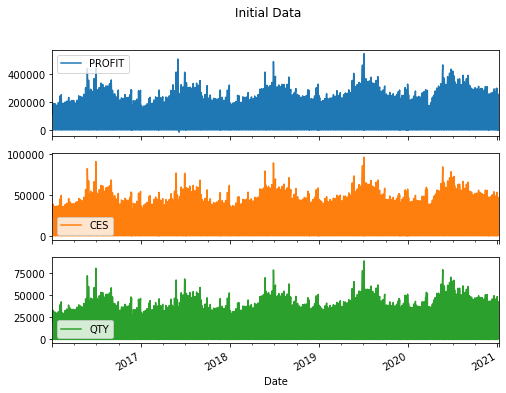

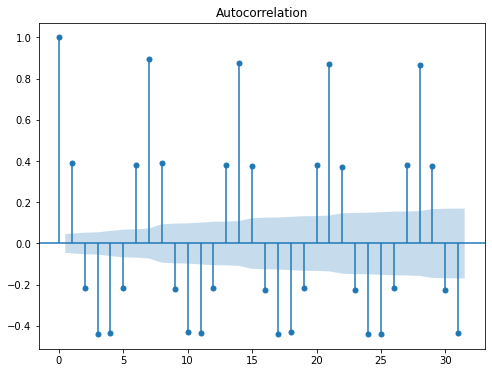

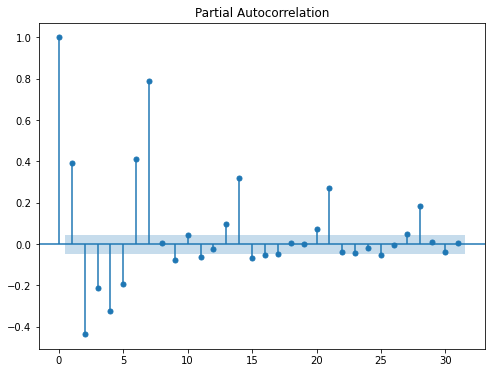

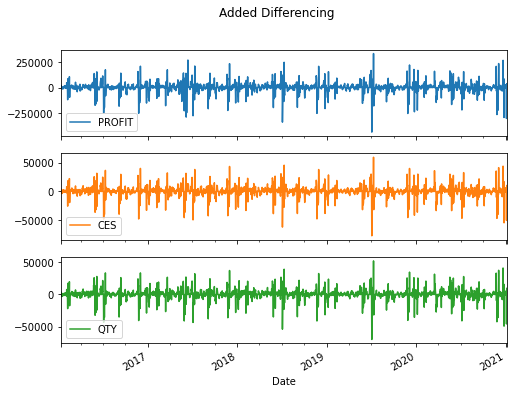

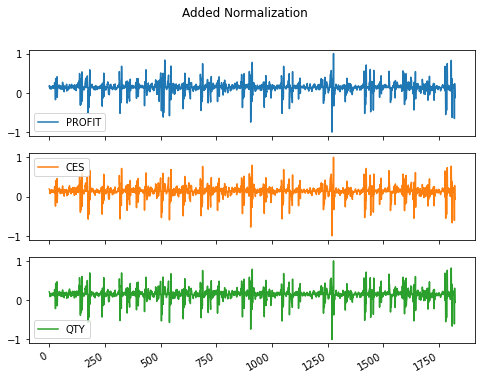

In [162]:
obj = schema_ML(schema, features)

Index(['PROFIT (t-1)', 'CES (t-1)', 'QTY (t-1)', 'PROFIT (t-7)', 'CES (t-7)',
       'QTY (t-7)', 'PROFIT (t-14)', 'CES (t-14)', 'QTY (t-14)',
       'PROFIT (t-21)', 'CES (t-21)', 'QTY (t-21)'],
      dtype='object')
Epoch 1/500
51/51 - 3s - loss: 0.0960 - val_loss: 0.0847
Epoch 2/500
51/51 - 0s - loss: 0.0733 - val_loss: 0.0815
Epoch 3/500
51/51 - 0s - loss: 0.0709 - val_loss: 0.0804
Epoch 4/500
51/51 - 0s - loss: 0.0697 - val_loss: 0.0791
Epoch 5/500
51/51 - 0s - loss: 0.0685 - val_loss: 0.0774
Epoch 6/500
51/51 - 0s - loss: 0.0674 - val_loss: 0.0763
Epoch 7/500
51/51 - 0s - loss: 0.0672 - val_loss: 0.0768
Epoch 8/500
51/51 - 0s - loss: 0.0670 - val_loss: 0.0760
Epoch 9/500
51/51 - 0s - loss: 0.0668 - val_loss: 0.0752
Epoch 10/500
51/51 - 0s - loss: 0.0665 - val_loss: 0.0761
Epoch 11/500
51/51 - 0s - loss: 0.0664 - val_loss: 0.0751
Epoch 12/500
51/51 - 0s - loss: 0.0662 - val_loss: 0.0751
Epoch 13/500
51/51 - 0s - loss: 0.0660 - val_loss: 0.0751
Epoch 14/500
51/51 - 0s - loss: 0.065

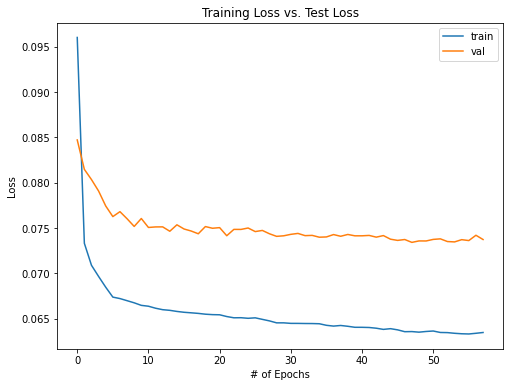

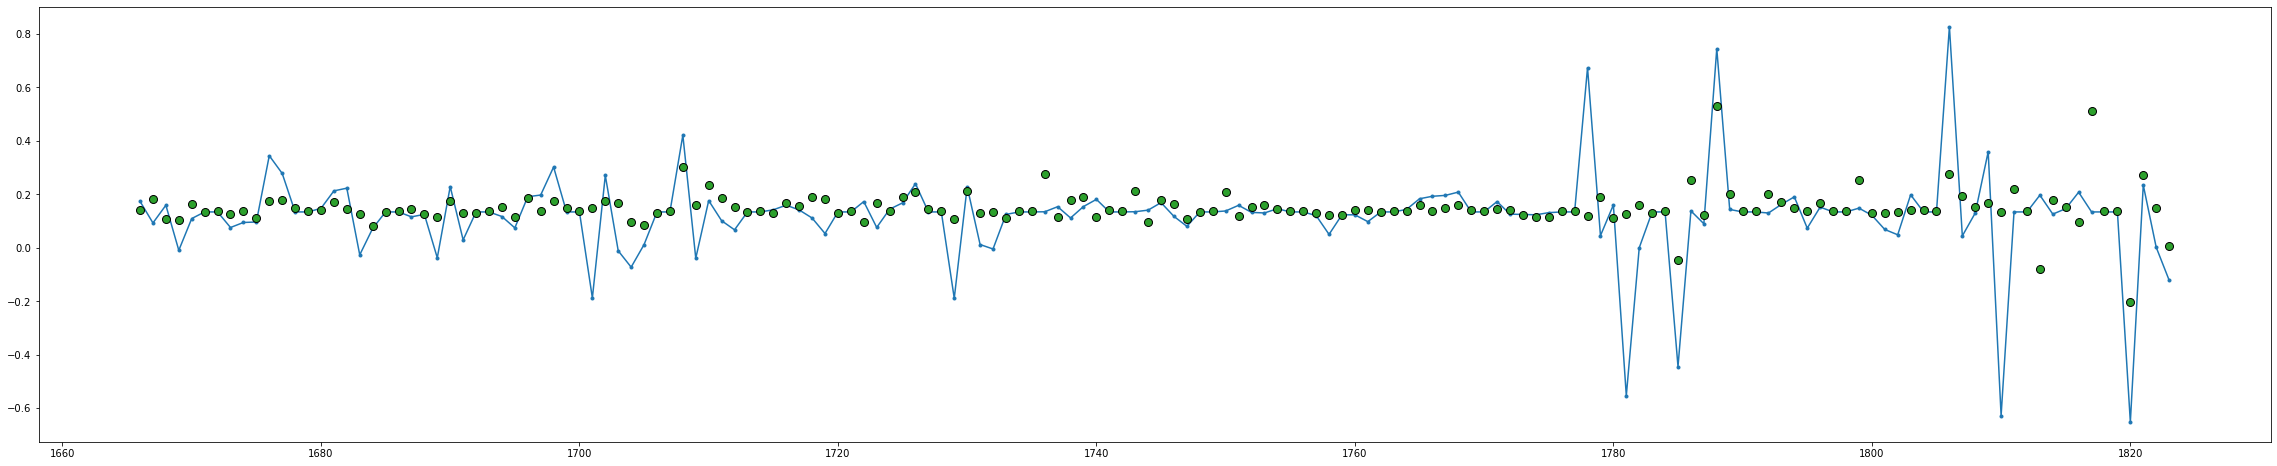

In [163]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'Base LSTM'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


Epoch 1/500
51/51 - 4s - loss: 0.0820 - val_loss: 0.0559
Epoch 2/500
51/51 - 0s - loss: 0.0343 - val_loss: 0.0237
Epoch 3/500
51/51 - 0s - loss: 0.0192 - val_loss: 0.0151
Epoch 4/500
51/51 - 0s - loss: 0.0176 - val_loss: 0.0156
Epoch 5/500
51/51 - 0s - loss: 0.0174 - val_loss: 0.0146
Epoch 6/500
51/51 - 0s - loss: 0.0175 - val_loss: 0.0149
Epoch 7/500
51/51 - 0s - loss: 0.0172 - val_loss: 0.0146
Epoch 8/500
51/51 - 0s - loss: 0.0168 - val_loss: 0.0134
Epoch 9/500
51/51 - 0s - loss: 0.0170 - val_loss: 0.0151
Epoch 10/500
51/51 - 0s - loss: 0.0169 - val_loss: 0.0140
Epoch 11/500
51/51 - 0s - loss: 0.0168 - val_loss: 0.0139
Epoch 12/500
51/51 - 0s - loss: 0.0166 - val_loss: 0.0136
Epoch 13/500
51/51 - 0s - loss: 0.0165 - val_loss: 0.0139
Epoch 14/500
51/51 - 0s - loss: 0.0160 - val_loss: 0.0133
Epoch 15/500
51/51 - 0s - loss: 0.0158 - val_loss: 0.0138
Epoch 16/500
51/51 - 0s - loss: 0.0161 - val_loss: 0.0136
Epoch 17/500
51/51 - 0s - loss: 0.0163 - val_loss: 0.0137
Epoch 18/500
51/51 - 0s

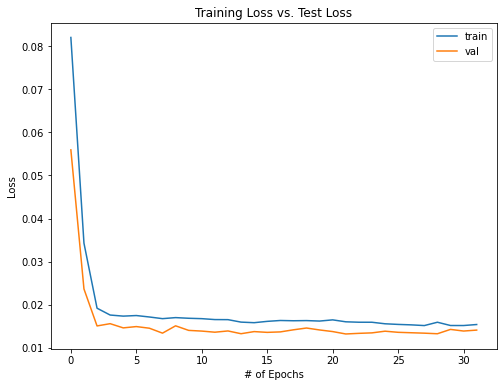

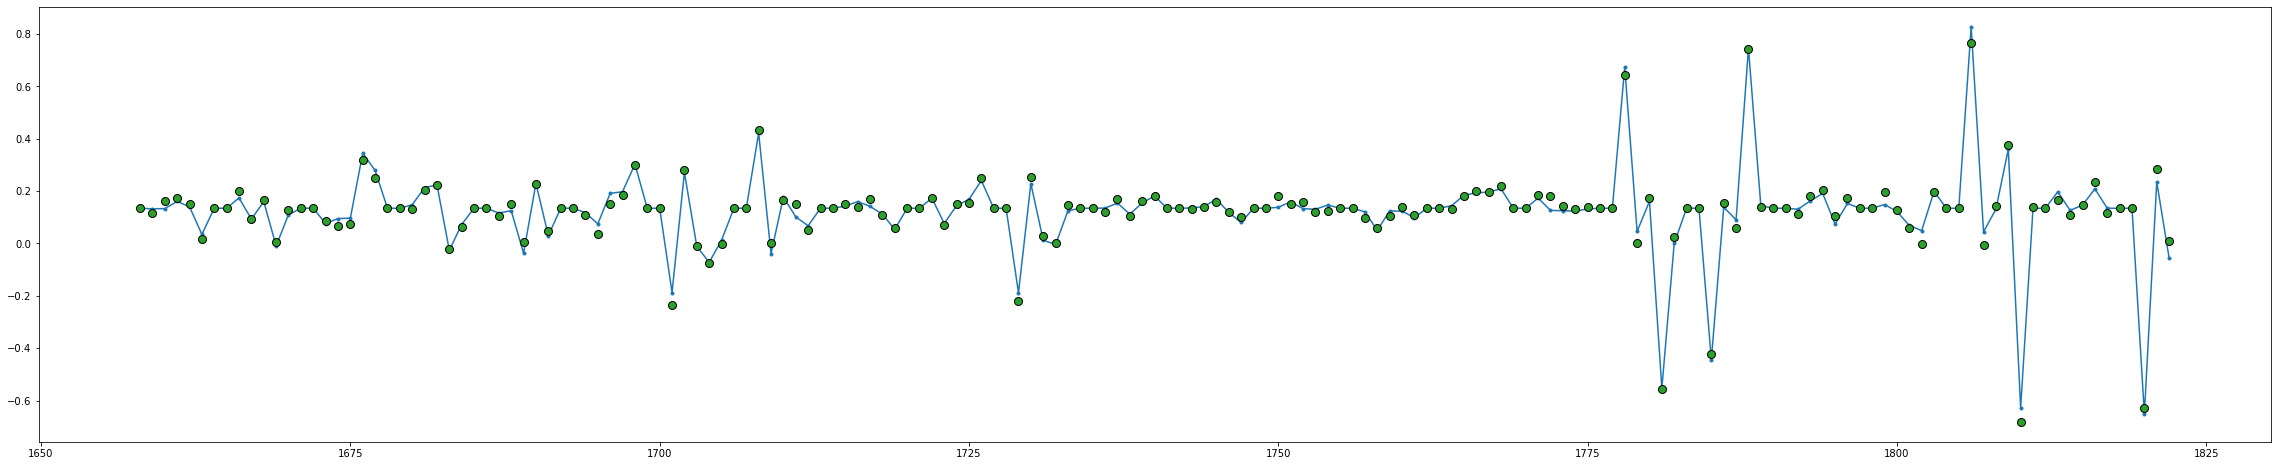

In [32]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_1'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


Epoch 1/500
52/52 - 5s - loss: 0.0791 - val_loss: 0.0495
Epoch 2/500
52/52 - 0s - loss: 0.0299 - val_loss: 0.0160
Epoch 3/500
52/52 - 0s - loss: 0.0210 - val_loss: 0.0151
Epoch 4/500
52/52 - 0s - loss: 0.0203 - val_loss: 0.0179
Epoch 5/500
52/52 - 0s - loss: 0.0203 - val_loss: 0.0146
Epoch 6/500
52/52 - 0s - loss: 0.0196 - val_loss: 0.0151
Epoch 7/500
52/52 - 0s - loss: 0.0196 - val_loss: 0.0160
Epoch 8/500
52/52 - 0s - loss: 0.0196 - val_loss: 0.0152
Epoch 9/500
52/52 - 0s - loss: 0.0190 - val_loss: 0.0148
Epoch 10/500
52/52 - 0s - loss: 0.0194 - val_loss: 0.0148
Epoch 11/500
52/52 - 0s - loss: 0.0187 - val_loss: 0.0159
Epoch 12/500
52/52 - 0s - loss: 0.0184 - val_loss: 0.0149
Epoch 13/500
52/52 - 0s - loss: 0.0190 - val_loss: 0.0158
Epoch 14/500
52/52 - 0s - loss: 0.0189 - val_loss: 0.0146
Epoch 15/500
52/52 - 0s - loss: 0.0185 - val_loss: 0.0149
Epoch 16/500
52/52 - 0s - loss: 0.0186 - val_loss: 0.0142
Epoch 17/500
52/52 - 0s - loss: 0.0188 - val_loss: 0.0148
Epoch 18/500
52/52 - 0s

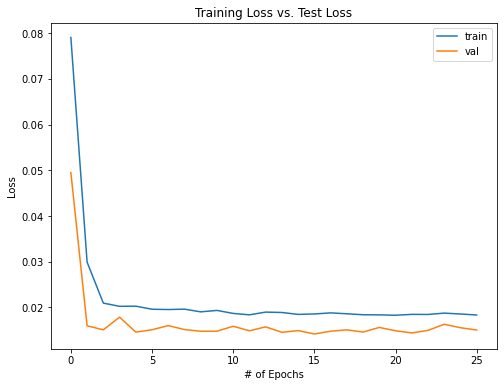

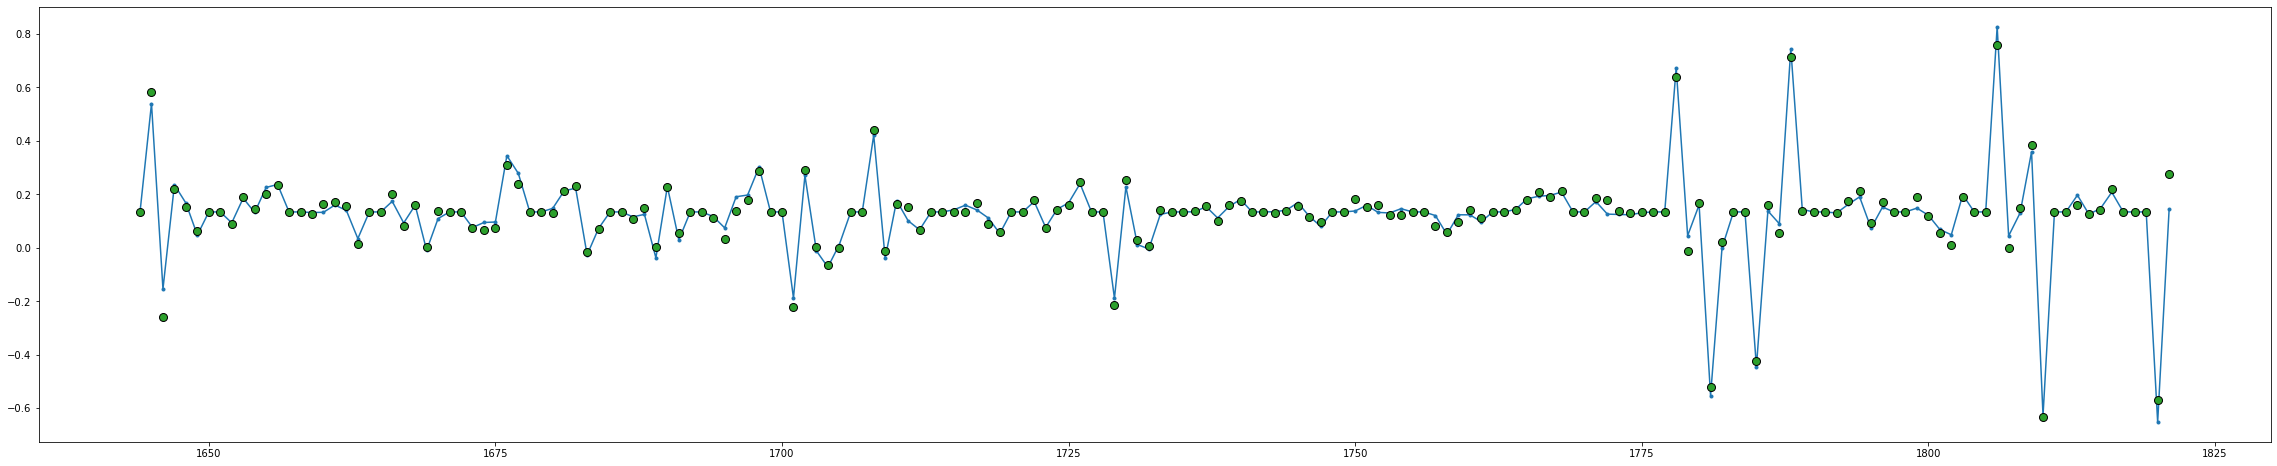

In [10]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_2'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


Epoch 1/500
52/52 - 5s - loss: 0.0815 - val_loss: 0.0550
Epoch 2/500
52/52 - 0s - loss: 0.0356 - val_loss: 0.0176
Epoch 3/500
52/52 - 0s - loss: 0.0240 - val_loss: 0.0149
Epoch 4/500
52/52 - 0s - loss: 0.0232 - val_loss: 0.0159
Epoch 5/500
52/52 - 0s - loss: 0.0220 - val_loss: 0.0163
Epoch 6/500
52/52 - 0s - loss: 0.0218 - val_loss: 0.0157
Epoch 7/500
52/52 - 0s - loss: 0.0223 - val_loss: 0.0162
Epoch 8/500
52/52 - 0s - loss: 0.0225 - val_loss: 0.0152
Epoch 9/500
52/52 - 0s - loss: 0.0214 - val_loss: 0.0148
Epoch 10/500
52/52 - 0s - loss: 0.0220 - val_loss: 0.0152
Epoch 11/500
52/52 - 0s - loss: 0.0208 - val_loss: 0.0152
Epoch 12/500
52/52 - 0s - loss: 0.0202 - val_loss: 0.0146
Epoch 13/500
52/52 - 0s - loss: 0.0213 - val_loss: 0.0154
Epoch 14/500
52/52 - 0s - loss: 0.0207 - val_loss: 0.0147
Epoch 15/500
52/52 - 0s - loss: 0.0201 - val_loss: 0.0158
Epoch 16/500
52/52 - 0s - loss: 0.0205 - val_loss: 0.0148
Epoch 17/500
52/52 - 0s - loss: 0.0202 - val_loss: 0.0146
Epoch 18/500
52/52 - 0s

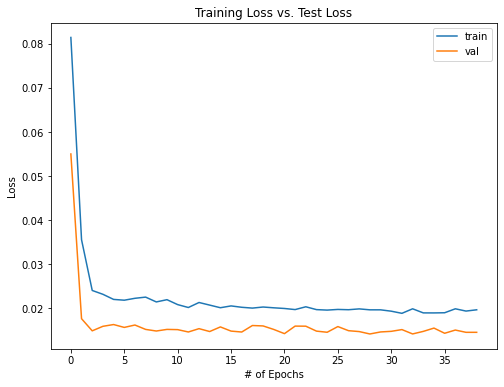

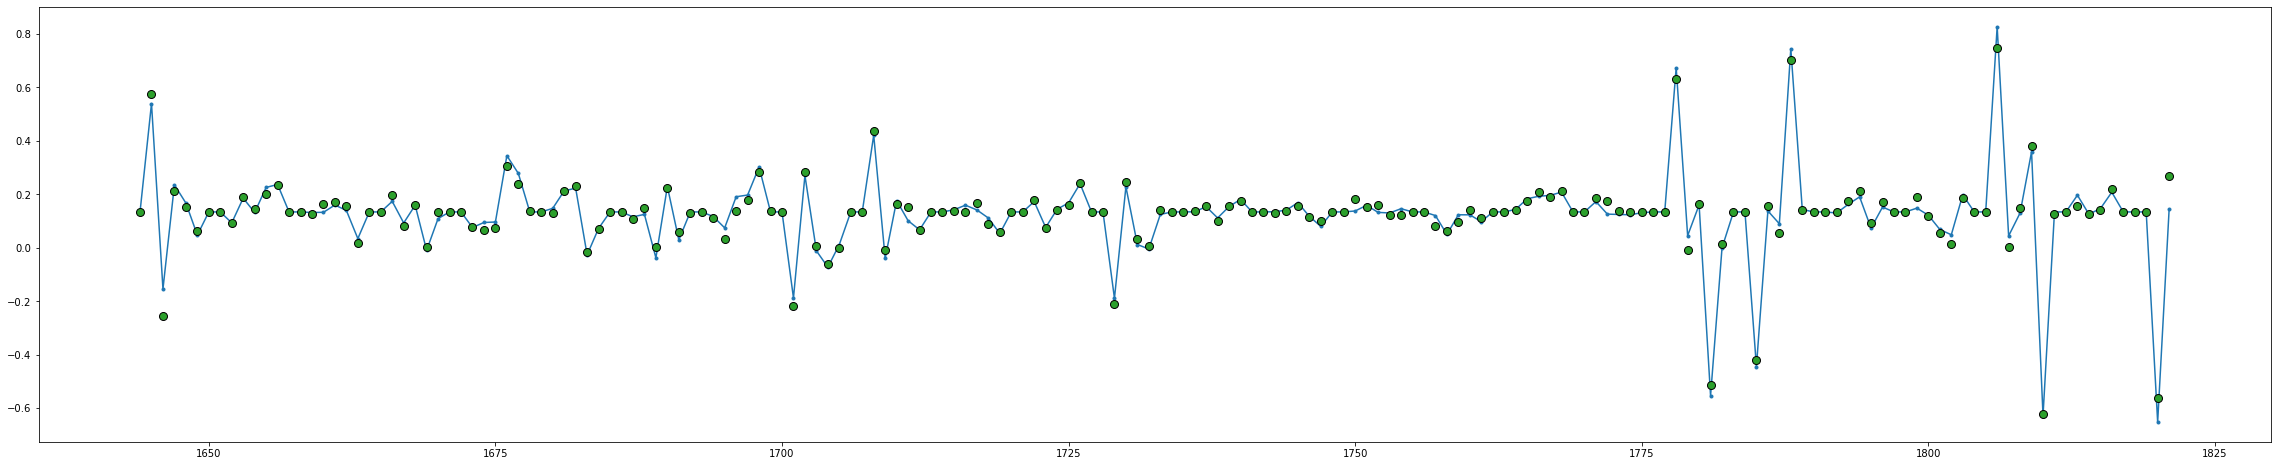

In [11]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_3'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)

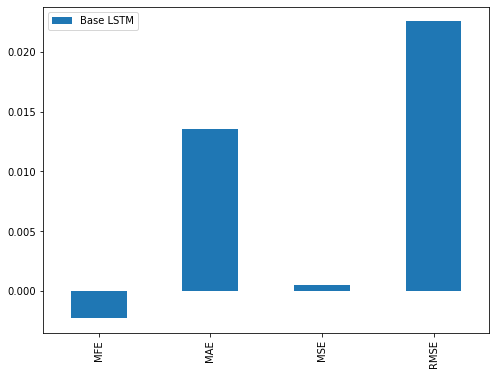

      Base LSTM
MFE   -0.002275
MAE    0.013556
MSE    0.000508
RMSE   0.022544


In [60]:
obj.performance_metrics()